In [3]:
## Evaluate Annotated Trees ##

#import requests
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score 
import math
import seaborn as sns
import shutil
import sys
import traceback
#from mlxtend.plotting import plot_confusion_matrix
 

In [4]:
sys.path.insert(0, "../dbh_estimation_algorithm_FastAPI/scripts")


In [5]:
import pixel_analyzer as pa 
from PIL import Image
#import PIL
from numpy import asarray

Can not import scripts


In [6]:
trunk = [0,85,0]
def isVertical(seg_image):
    """ Takes a numpy array version of an image and return true if the tree in the image is vertical"""
    Y, X, a = np.where(seg_image == trunk)
    y_length = np.max(Y) - np.min(Y)
    x_length = np.max(X) - np.min(X)

    if (y_length/len(seg_image)) > x_length/len(seg_image[0]):
        return True
    return False

In [7]:
# load measured and predicted dbh values
calibration_data = pd.read_csv('../statistical_analysis/output/calibration_dataset.csv')

In [8]:
#calibration_data

In [9]:
# just need the tree_picture id, and the measured dbh values for calibration with the ratio
df3 = calibration_data[["tree_picture", "measured_dbh"]]
df3.head()

,tree_picture,measured_dbh
0,1675934453966.jpg,38.5
1,1675844836804.jpg,5.0
2,1675329532298.jpg,12.9
3,1675149973263.jpg,38.0
4,1675323368595.jpg,7.0


In [10]:
# get predictions for dbh based on true annotations

measured_dbhs = []
ratios = []
image_files = []
zoom_files = []
annotated_trees_path = '../statistical_analysis/data/annotated_trees'
for temp_image  in os.listdir(annotated_trees_path):
    zoom_file = False

    try:

        seg_image = Image.open(os.path.join(annotated_trees_path, temp_image))
        seg_image1 = asarray(seg_image)
        if not isVertical(seg_image1):
            seg_image = seg_image.transpose(Image.ROTATE_90)
            seg_image1 = asarray(seg_image)
        try:
            image_file = temp_image.split("_")[2] + ".jpg"
            measured_dbh = df3[df3['tree_picture'] == image_file]['measured_dbh'].tolist()[0]
            ratio = pa.getTreePixelWidth(seg_image1, image_file.split(".")[0] , measured_dbh, False, True)
        except:
            zoom_file = True
            image_file = temp_image.split("_")[3] + ".jpg"
            measured_dbh = df3[df3['tree_picture'] == image_file]['measured_dbh'].tolist()[0]
            ratio = pa.getTreePixelWidth(seg_image1, image_file.split(".")[0] , measured_dbh, False, True)

        measured_dbhs.append(measured_dbh)
        ratios.append(ratio)
        image_files.append(image_file)
        zoom_files.append(zoom_file)
    except:
        print(traceback.format_exc())
        print(temp_image)

Traceback (most recent call last):
  File "/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_26048/1203044228.py", line 20, in <cell line: 8>
    measured_dbh = df3[df3['tree_picture'] == image_file]['measured_dbh'].tolist()[0]
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_26048/1203044228.py", line 25, in <cell line: 8>
    measured_dbh = df3[df3['tree_picture'] == image_file]['measured_dbh'].tolist()[0]
IndexError: list index out of range

resized_original_1675061030506_color_mask.png
Traceback (most recent call last):
  File "/var/folders/t7/8xb6r8jx3_bd842lt0tnr6sr0000gn/T/ipykernel_26048/1203044228.py", line 13, in <cell line: 8>
    seg_image = Image.open(os.path.join(annotated_trees_path, temp_image))
  File "/Users/edwardamoah/opt/anaconda3/envs/env_tensorflow/lib/python3.9/site-packages/PIL/Image.py", line 29

In [11]:
df = pd.DataFrame({
    "measured_dbh": measured_dbhs,
    "ratio": ratios,
    "tree_pictures": image_files,
    "zoom_file": zoom_files
})
df.head()

,measured_dbh,ratio,tree_pictures,zoom_file
0,23.6,3.366971,1675152045531.jpg,False
1,28.3,3.765978,1675152298141.jpg,True
2,25.0,3.262570,1675151454814.jpg,False
3,20.0,3.163814,1675243337239.jpg,True
4,40.7,6.089423,1675157721989.jpg,False


In [12]:
df1 = df[df["zoom_file"]== True]
print(len(df1))
df1.head()

52


,measured_dbh,ratio,tree_pictures,zoom_file
1,28.3,3.765978,1675152298141.jpg,True
3,20.0,3.163814,1675243337239.jpg,True
5,16.7,2.665628,1675149279494.jpg,True
12,10.4,1.775979,1675065957914.jpg,True
13,23.2,3.430394,1675073200688.jpg,True


In [13]:
# save algorithm calibiration dataset
#df1[["tree_pictures","ratio","measured_dbh"]].to_csv("output/dbh_algorithm_calibiration_dataset.csv")

In [14]:
import pandas as pd
import statsmodels.formula.api as smf

In [15]:
calibration_data = df1[["ratio", "measured_dbh"]]

model = smf.ols('measured_dbh ~ ratio', data=calibration_data)
model = model.fit()

# prediction function
def getPrediction(ratio):
    try:
        new_X = float(ratio)
        pred = model.predict({"ratio": new_X})
        return round(pred.tolist()[0],2)
    except:
        return None

In [16]:
#calibration_data['predicted_dbh'] = calibration_data['ratio'].apply(getPrediction)

Text(0.5, 1.0, 'Algorithm Calibration Linear Regression Model (n=52)')

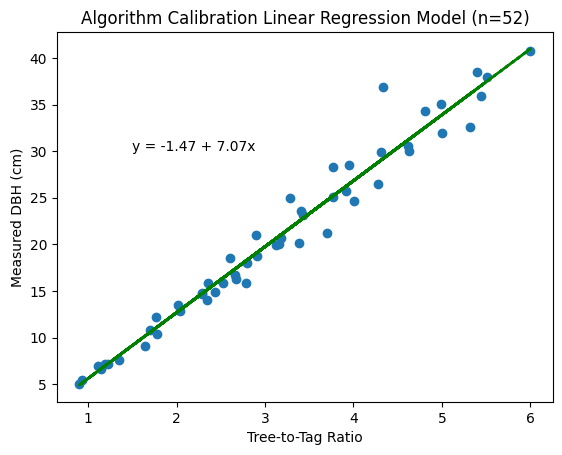

In [17]:
plt.scatter(calibration_data['ratio'], calibration_data['measured_dbh'])

x = np.array(calibration_data['ratio']); y = np.array( [ float(x) for x in calibration_data['measured_dbh']])
a, b = np.polyfit(x, y , 1)

#plt.scatter(x, y, color='purple')
plt.plot(x, a*x+b, linestyle='--', linewidth=2, color='green')

# add fitted regression equation to plot
plt.text(1.5, 30, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)


plt.ylabel("Measured DBH (cm)")
plt.xlabel("Tree-to-Tag Ratio")
plt.title("Algorithm Calibration Linear Regression Model (n=52)")